In [1]:
#%pip install nltk
#%pip install --upgrade pip
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

In [2]:
import pickle
with open("data.pkl", "rb") as f:
    questions_matrix, data, best_num_clusters, tfidf_vectorizer = pickle.load(f)

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_question(user_question):
    # Convertir la question en minuscules
    user_question = user_question.lower()

    # Supprimer la ponctuation
    user_question = re.sub(r'[^\w\s]', '', user_question)

    # Tokenization
    tokens = word_tokenize(user_question)

    # Supprimer les mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Reconstruire la question à partir des tokens lemmatisés
    processed_question = ' '.join(tokens)

    return processed_question

In [5]:
preprocess_question(user_question)

''

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [7]:
user_question_vector = tfidf_vectorizer.transform([preprocess_question(user_question)])

print(user_question_vector.shape)
print(questions_matrix.shape)

cluster_similarities = cosine_similarity(user_question_vector, questions_matrix)

(1, 186298)
(54454, 186298)


In [8]:
cluster_similarities.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

In [9]:
cosine_similarities = cosine_similarity(user_question_vector, questions_matrix).flatten()
similarities_data = pd.DataFrame({
    'question_id': data['question_id'],
    'similarity': cosine_similarities,
    'cluster': data['cluster'],
    'answer_id': data['answer_id']
})

In [10]:
similarities_data.head(4)

,question_id,similarity,cluster,answer_id
0,4911362,0.0,3,4911381
1,4911084,0.0,1,4911116
2,4903217,0.0,1,4903315
3,4903217,0.0,1,4904982


In [11]:
print("Top 10 similar questions:")
print(similarities_data.sort_values(by='similarity', ascending=False).head(10))

Top 10 similar questions:
       question_id  similarity  cluster  answer_id
0          4911362         0.0        3    4911381
36294      4901933         0.0        2    4907469
36296      4906723         0.0        5    4906743
36297      4905484         0.0        4    4905692
36298      4905484         0.0        4    4907271
36299      4901924         0.0        5    4902125
36300      4901924         0.0        5    4901943
36301      1780129         0.0        5    4907454
36302      4906339         0.0        5    4907432
36303      4907350         0.0        5    4907376


In [12]:
# Trouver la question la plus similaire
most_similar_question = similarities_data.loc[similarities_data['similarity'].idxmax()]

# Cluster du question la plus similaire
predicted_cluster = most_similar_question['cluster']
print(f"Predicted cluster for the new question: {predicted_cluster}")

Predicted cluster for the new question: 3.0


In [13]:
# Récupération des réponses du cluster prédit
cluster_responses = data[data['cluster'] == predicted_cluster]

# Calcul de la similarité entre la nouvelle question et les questions du cluster
cluster_cosine_similarities = cosine_similarity(user_question_vector, tfidf_vectorizer.transform(cluster_responses['body_x'])).flatten()

# Ajout des similarités au DataFrame du cluster
cluster_responses = cluster_responses.assign(similarity=cluster_cosine_similarities)

In [14]:
print("Similarities within the predicted cluster:")
print(cluster_responses[['body_x', 'similarity']].sort_values(by='similarity', ascending=False).head(10))

Similarities within the predicted cluster:
                                                  body_x  similarity
0      given pdf x denote fx fx begincases frac194 x2...         0.0
35533  attempt consider integral beginalign i_1 amp i...         0.0
35261  steele quotthe cauchyschwarz master classquot ...         0.0
35426  beginaligned sum_k1n k3 amp 182764cdotsn3 amp ...         0.0
35427  beginaligned sum_k1n k3 amp 182764cdotsn3 amp ...         0.0
35428  beginaligned sum_k1n k3 amp 182764cdotsn3 amp ...         0.0
35438  wikipedia page beta function give simple formu...         0.0
35463  matrix beginbmatrix 1 amp 0 amp 1 amp 2 1 amp ...         0.0
35464  matrix beginbmatrix 1 amp 0 amp 1 amp 2 1 amp ...         0.0
35470  im trying solve exercise book arithmetic ellip...         0.0


In [15]:
# Récupérer les indices des réponses les plus similaires dans le cluster
most_similar_indices_in_cluster = cluster_responses['similarity'].nlargest(5).index

# Récupérer les réponses recommandées dans une liste
recommended_responses = cluster_responses.loc[most_similar_indices_in_cluster, 'body_y'].tolist()

# Supprimer les réponses dupliquées tout en préservant l'ordre
seen = set()
unique_recommended_responses = []
for response in recommended_responses:
    if response not in seen:
        unique_recommended_responses.append(response)
        seen.add(response)

# Afficher les réponses recommandées sous forme de liste
print("Les réponses recommandées sont:\n:")
for i, response in enumerate(unique_recommended_responses, start=1):
    print(f"{i}. {response}"+"\n*************************************************\n")

Les réponses recommandées sont:
:
1. The formula for the CDF is Fyint_inftyy fxdx so we apply this formula If ygeq2 then Fyint_12frac194x2dx 1 When yleq1 Fyint_inftyy0dx0 and when 1lt y lt2 we have Fyint_1y frac19left4x2right d xfrac127lefty312 y11right
*************************************************

2. It is well known that prod_n1inftyfrac1qn1qntheta_4qsum_ninftyinfty1nqn212q2q42q9 Where theta_4q is the fourth Jacobi theta function at z0
*************************************************

3. The theta4 function can be expressed a an infinite product theta_4leftzqrightprodlimits_n1inftyleft1q2nright left12q2n1cosleft2zrightq4n2right With z0 theta_4left0qrightprodlimits_n1inftyleft1q2nright left12q2n1q4n2right prodlimits_n1inftyleft1q2nright left1q2n1right2 Now note the following identity for infinite product prod_n0infty1qn prod_n1inftyfrac1q2n1qnprod_n1inftyfrac11q2n1 you get theta_4left0qrightprodlimits_n1inftyleft1q2nright left1q2n1right2 prodlimits_n1inftyfrac1qn1qn tag1 Lets pr

In [16]:
# Convertir les similarités en DataFrame pour une meilleure visualisation
similarities_df = pd.DataFrame(cluster_similarities.T, index=data.index, columns=['similarity'])

# Ajouter les similarités au DataFrame original
data = data.join(similarities_df)

In [17]:
# Identifier le cluster de la question la plus similaire
most_similar_question_idx = data['similarity'].idxmax()
predicted_cluster = data.loc[most_similar_question_idx, 'cluster']
print(predicted_cluster)

3


In [18]:
# Sélectionner les réponses des questions du même cluster avec une similarité > 80%
recommended_responses = data[(data['cluster'] == predicted_cluster) & (data['similarity'] >= 0.8)][['answer_id', 'body_y']]
recommended_answers = pd.DataFrame(recommended_responses).drop_duplicates()

print("Les réponses recommandées sont:\n",recommended_answers['body_y'].head())

Les réponses recommandées sont:
 Series([], Name: body_y, dtype: object)


In [19]:
data.head(3)

,_id_x,question_id,body_x,_id_y,answer_id,score_y,body_y,view_count,is_answered,cluster,similarity
0,6637bb13dde473a4efd9d878,4911362,given pdf x denote fx fx begincases frac194 x2...,6637c5a9dde473a4efdbd575,4911381,0,The formula for the CDF is Fyint_inftyy fxdx s...,2,0,3,0.0
1,6637bb13dde473a4efd9d879,4911084,solve following boundary value problem laplace...,6637c1acdde473a4efdbbd3f,4911116,-1,The solution form you have written is for a di...,27,0,1,0.0
2,6637bb13dde473a4efd9d87a,4903217,given total derivative df sufficiently smooth ...,6637befedde473a4efda91d5,4903315,1,defR1mathbb R1 defnnabla defBR1big1big defLR1l...,80,1,1,0.0


In [20]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [21]:
# Prétraiter les questions
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Limiter le nombre de caractéristiques
tfidf_matrix = tfidf_vectorizer.fit_transform(data['body_x'])

# Appliquer le clustering KMeans
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [22]:
# Créer et entraîner un modèle Keras
input_dim = tfidf_matrix.shape[1]

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(best_num_clusters, activation='softmax'))  # n_clusters est le nombre de clusters
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Entraîner le modèle
X_train = tfidf_matrix.toarray()
y_train = data['cluster'].values
history = model.fit(X_train, y_train, epochs=8, batch_size=16, validation_split=0.2)

Epoch 1/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.8228 - loss: 0.5421 - val_accuracy: 0.9869 - val_loss: 0.0428
Epoch 2/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 56s 20ms/step - accuracy: 0.9916 - loss: 0.0282 - val_accuracy: 0.9904 - val_loss: 0.0251
Epoch 3/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.9973 - loss: 0.0093 - val_accuracy: 0.9979 - val_loss: 0.0068
Epoch 4/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 0.9983 - val_loss: 0.0039
Epoch 5/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 50s 18ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 6/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 97s 24ms/step - accuracy: 0.9998 - loss: 7.9800e-04 - val_accuracy: 0.9986 - val_loss: 0.0035
Epoch 7/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9983 - val_loss: 0.0067
Epoch 8/8
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 76s 18ms/step - accuracy: 0.9984 - los

In [24]:
# Fonction pour recommander des réponses
def recommend_responses(new_question, model, df, tfidf_vectorizer, top_n=5):
    # Prétraiter la nouvelle question
    new_question_vector = tfidf_vectorizer.transform([new_question])

    # Prédire le cluster de la nouvelle question
    new_question_vector_array = new_question_vector.toarray()
    predicted_cluster = np.argmax(model.predict(new_question_vector_array), axis=1)[0]

    # Récupérer les questions et réponses du cluster prédit
    cluster_questions = df[df['cluster'] == predicted_cluster]

    # Calculer la similarité cosinus entre la nouvelle question et les questions du cluster
    cluster_question_vectors = tfidf_vectorizer.transform(cluster_questions['body_x'])
    similarities = cosine_similarity(new_question_vector, cluster_question_vectors).flatten()

    # Ajouter la similarité au DataFrame des questions du cluster
    cluster_questions = cluster_questions.assign(similarity=similarities)

    # Récupérer les indices des réponses les plus similaires dans le cluster
    most_similar_indices_in_cluster = cluster_questions['similarity'].nlargest(top_n).index

    # Récupérer les réponses recommandées dans une liste
    recommended_responses = cluster_questions.loc[most_similar_indices_in_cluster, 'body_y'].tolist()

    # Supprimer les réponses dupliquées tout en préservant l'ordre
    seen = set()
    unique_recommended_responses = []
    for response in recommended_responses:
        if response not in seen:
            unique_recommended_responses.append(response)
            seen.add(response)

    return unique_recommended_responses

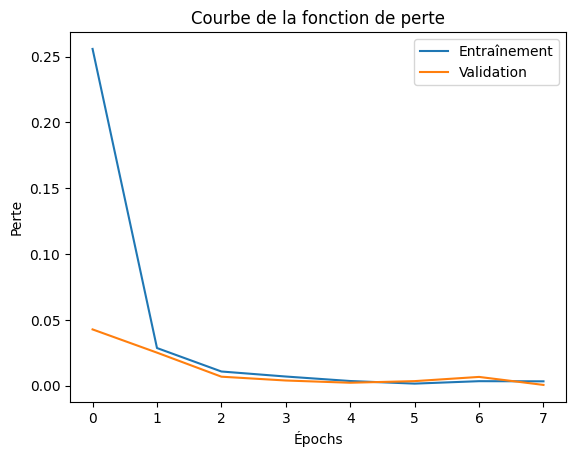

In [25]:
# Tracer la courbe de la fonction de perte
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de la fonction de perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()
plt.show()

1702/1702 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


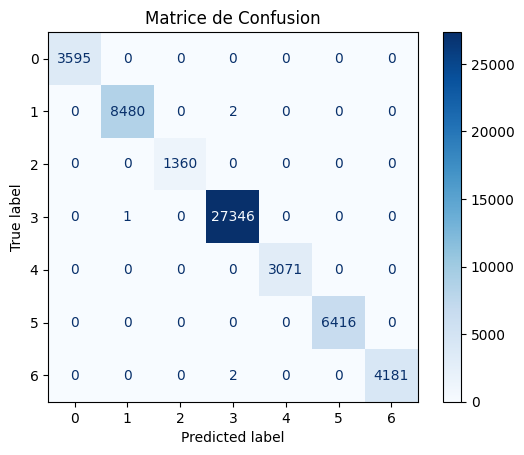

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_train)
y_pred_clusters = np.argmax(y_pred, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_train, y_pred_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

# Afficher la matrice de confusion
plt.title('Matrice de Confusion')
plt.show()

In [27]:
# Obtenir les réponses recommandées
recommended_responses = recommend_responses(preprocess_question(user_question), model, data, tfidf_vectorizer)

# Afficher les réponses recommandées sous forme de liste
print("Recommended responses:")
for i, response in enumerate(recommended_responses, start=1):
    print(f"{i}. {response}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Recommended responses:
1. defR1mathbb R1 defnnabla defBR1big1big defLR1left1right defop1operatorname1 defcurl1opcurlLR1 defgrad1opgradLR1 defskew1opskewLR1 defcross1oplargePsiLR1 defqquad defqqqquad defqifqiffq defqiqqimpliesq defwwedge defttimes defppartial defderiv12fracp 1p 2 defm1leftbeginarrayc1endarrayright In R3 the sf Cross Product Matrix CPM of a vector b is defined a eqalign cross b doteq m 0ampb_3ampb_2 b_3amp0ampb_1 b_2ampb_1amp0 Now consider the sf CPM of the cross product of two vector eqalign crossbt a amp LRabTbaT doteq 2skewbaT Substituting the b vector with the n operator yield eqalign crossnt a amp 2skewn aT amp 2skewgrad a In higher dimension neither the cross product nor the curl exist but the gradient doe And the skew part of the gradient is the nearest analog of the curl operation
2. newcommandddmathrm D newcommandTrmathopmathrmTr Let V be our real ndimensional vector space Something that must be noted is that divergencebeing